<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/2_Variational_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from scipy.special import digamma, polygamma, loggamma

# **1. Preprocessing**

## **1-1. Load data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data path

train_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/train.txt"
test_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/test.txt"

In [4]:
def read_file(path):
  raw = open(path, 'r').read().split('\n') # 파일을 읽어와 줄마다 나누기
  data, doc = list(), list()

  for i, line in enumerate(raw):
    if line.strip(): # 빈 줄이 아니면
      word = line.split(' ')[0].lower() # 단어를 얻어온 후 소문자로 변환
      doc.append(word)
    else:
      data.append(doc) # EOD(End Of Document)
      doc = list()
  data.append(doc) # 맨 마지막 문서 추가

  return data

In [5]:
# 데이터 불러오기
org_train_data = read_file(train_path)
org_test_data = read_file(test_path)

# 맨 마지막 문서는 제거
del org_train_data[-1], org_test_data[-1]

## **1-2. Preprocess Data**

In [6]:
# some words that we do not want to consider
stopwords = ["", " ", 'the', 'to', 'of', 'a', 'and', 'in', 'for', "s", 'that', 'is', 'said', 'mr', 'on', 'by',
             'it', 'as', 'was', 'at', 'with', 'from', 'its', 'an', 'has', 'he', 'be', 'but', 'are', 'will',
             'have', 'or', "nt", 'his', 'they', 'were', 'this', 'which', 'would', 'about', 'year', 'had', 'been',
             'more', 'than', 'who', 'up', 'also', 'other', 'after', 'we', 'says', 'their', 'one', 'two', 'lrb',
             'rrb', 'years', 'when', 'some', 'may', 'could', 'quarter', 'yesterday', 'most', 'not', 'if',
             'because', 'there', 'first', 'i', 'any', 'last', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
             'saturday', 'sunday', 'before', 'no', 'week', 'much', 'so', 'such', 'can', 'while', 'into', 'do',
             'then', 'many', 'out', 'less', 'against', 'even', 'under', 'only', 'since', 'however', 'over', 'among',
             'between', 'them', 'him', 'those', 'did', 'you', 'still', 'these', 'three', 'own', 'second', 'off',
             'all', 'what', 'both', 'day', 'now', 'yet', 'during', 'according', 'including', 'she', 'my', 'days',
             'due', 'your', 'her', 'another', 'just', 'does', 'our', 'how', 'through', 'where', 'too', 'very', 'each',
             'days', 'month', 'months', 'should', 'several', 'few', 'ago']

In [7]:
## remove numbers, special characters, etc.
# only consider words with alphabet

def only_alphabet(corpus, stopword_list=stopwords):
    pattern = re.compile('[^a-z]')
    # non-alphabet 문자 제거(=> 정규표현식 활용)
    return [
        [pattern.sub('', word) for word in doc if pattern.sub('', word) not in stopword_list] for doc in corpus
    ]

In [8]:
train_data = only_alphabet(org_train_data)
test_data = only_alphabet(org_test_data)

In [9]:
## count word occurrence in corpus

def count_vocab(corpus):
  vocab = defaultdict(int) # dictionary 형태로 word occurence를 기록
  for doc in corpus:
    for word in doc:
      vocab[word] += 1

  return vocab

In [10]:
vocab_count = count_vocab(train_data)

In [11]:
## 특정 빈도수 이상인 단어들만 고려
# sparse한 단어는 무시

def vocab_top(vocab,cnt):
  return {voca: count for voca, count in vocab.items() if count > cnt}

In [12]:
vocab_count = vocab_top(vocab_count,cnt = 5)

In [13]:
## filter out low-occurrence words

def filter_vocab(corpus, vocab):
    vocab_set = set(vocab)
    return [
        [word for word in doc if word in vocab_set] for doc in corpus
    ]

In [14]:
train_data = filter_vocab(train_data,vocab_count)
test_data = filter_vocab(test_data,vocab_count)

In [15]:
## construct voca-index-matching dictionary

def voca_index(vocab):
  vocab_to_index = {voca: i for i, voca in enumerate(vocab.keys())}
  index_to_vocab = {i: voca for i, voca in enumerate(vocab.keys())}

  return vocab_to_index, index_to_vocab

In [16]:
v_t_i, i_t_v = voca_index(vocab_count)

In [17]:
## convert corpus-with-words to corpus-with-index

def corpus_to_index(corpus,vocab_to_index):
  return [[vocab_to_index[word] for word in doc] for doc in corpus]

In [18]:
train_data_idx = corpus_to_index(train_data,v_t_i)
test_data_idx = corpus_to_index(test_data,v_t_i)

# **2. Modeling**

In [21]:
class LDA_VI:
  def __init__(self,docs, num_topic=10, vocab = None, alpha=1.,num_iter=100,lr=1e-3):
    self.docs = docs
    self.num_topic = num_topic
    self.vocab = vocab
    self.num_vocab = len(self.vocab)
    self.num_docs = len(self.docs)

    # Initialize alpha and beta
    self.alpha = np.ones(self.num_topic)*(1/self.num_topic)
    self.beta = np.ones((self.num_topic, self.num_vocab))*(1/self.num_vocab)
    # beta 초기값 업데이트
    self.beta += np.random.rand(self.num_topic, self.num_vocab) * 0.01
    self.beta /= np.sum(self.beta, axis=1)[:, np.newaxis]

    # Initialize gamma and phi
    self.gamma = np.ones((self.num_docs,self.num_topic))*(1/self.num_topic)
    self.phi = np.ones((self.num_docs, self.num_vocab, self.num_topic))*(1/self.num_topic)

    # Initialize z (topic assignments for words in documents)
    self.z = [[np.random.randint(0, self.num_topic) for _ in range(len(doc))] for doc in self.docs]

    # Initialize parameters for variational inference
    self.num_iter = num_iter
    self.lr = lr

    self.elbo_list = []  # ELBO 값을 저장할 리스트
    self.perp_list = []  # perplexity 값을 저장할 리스트
    self.coherence_list = [] # coherence 값을 저장할 리스트

  def update_gamma(self):
    ## Update gamma (document-topic distributions)
    self.gamma = self.alpha + np.sum(self.phi, axis = 1)

  def update_phi(self):
    ## Update phi (topic-word distributions)
    for d in range(self.num_docs):
      for n in range(len(self.docs[d])):
        word_idx = self.docs[d][n]
        self.phi[d, n] = self.beta[:, word_idx] * np.exp(digamma(self.gamma[d]))
    # phi 정규화(topic에 대해 정규화)
    self.phi /= np.sum(self.phi, axis = 2)[:, :, np.newaxis]

  def update_beta(self):
    ## Update beta(topic-word prior)
    for d in range(self.num_docs):
      for n in range(len(self.docs[d])):
        word_idx = self.docs[d][n]
        self.beta[:, word_idx] += self.phi[d, n]
    # beta 정규화(word에 대해 정규화)
    self.beta /= np.sum(self.beta, axis = 1)[:, np.newaxis]

  def update_alpha(self):
    ## Update alpha(document-topic prior)
    M = self.num_docs
    g = np.zeros(self.num_topic) # gradient
    H = np.zeros((self.num_topic, self.num_topic)) # Hessian matrix

    for i in range(self.num_topic):
      g[i] = M * ( digamma(np.sum(self.alpha)) - digamma(self.alpha[i]) )
      for d in range(M):
        g[i] += ( digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])) )
      for j in range(self.num_topic):
        H[i, j] = 0
        if i == j:
          H[i, j] -= M * polygamma(1, self.alpha[i])
        H[i, j] += M * (polygamma(1, np.sum(self.alpha)))

    # alpha 업데이트(=> Newton-Raphson)
    deltaAlpha = np.dot(np.linalg.inv(H), g)
    self.alpha -= deltaAlpha

  def e_step(self):
    ## Perform E-step of the variational inference
    self.update_phi()
    self.update_gamma()

  def m_step(self):
    ## Perform M-step of the variational inference
    self.update_beta()
    self.update_alpha()

  def compute_elbo(self):
    ## Compute Evidence Lower Bound (ELBO)

    # 필요한 파라미터 정의
    elbo = 0
    M = self.num_docs
    k = self.num_topic

    # 1번 수식
    for d in range(M): # document
      for n in range(len(self.docs[d])):
        j = self.docs[d][n] # word idx
        for i in range(k): # topic
          elbo += self.phi[d, n, i] * np.log(self.beta[i, j])

    # 2번 수식
    for d in range(M):
      for n in range(len(self.docs[d])):
        for i in range(k):
          elbo += self.phi[d, n, i] * (digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])))

    # 3번 수식
    for d in range(M):
      elbo += loggamma(np.sum(self.alpha))
      for i in range(k):
        elbo -= loggamma(self.alpha[i])
        elbo += (self.alpha[i] - 1) * (digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])))

    # 4번, 5번 수식
    for d in range(M):
      elbo -= loggamma(np.sum(self.gamma[d]))
      for i in range(k):
        elbo += loggamma(np.sum(self.gamma[d, i]))
        elbo -= (self.gamma[d, i] - 1)*( digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])) )
        for n in range(len(self.docs[d])):
          elbo -= self.phi[d, n, i] * np.log(self.phi[d, n, i])

    return elbo

  def compute_perplexity(self, elbo):
    # 분모
    N = sum(len(doc) for doc in self.docs)

    perplexity = np.exp(-elbo / N)
    return perplexity

  def compute_topic_coherence(self, top_n=10):
    coherence = 0.0

    # 모든 주제에 대해 계산
    for k in range(self.num_topic):
      # 각 주제에서 상위 top_n 단어 추출
      top_words = np.argsort(self.beta[k, :])[-top_n:]

      # 상위 단어 쌍의 coherence 계산
      for i in range(top_n):
        for j in range(i + 1, top_n):
          word_i = top_words[i]
          word_j = top_words[j]

          # Coherence 계산: log((P(word_j | topic_k) + 1) / sum(P(word_j | 모든 주제)))
          # P(word_j | topic_k)는 self.beta[k, word_j]로 표현됨
          word_j_given_topic_k = self.beta[k, word_j]
          word_j_given_all_topics = self.beta[:, word_j].sum()

          coherence += np.log((word_j_given_topic_k + 1e-12) / word_j_given_all_topics)

    # 주제 수로 나누어 평균 coherence 계산
    return coherence / self.num_topic

  def run(self):
    start_time = time.time()

    ## Run the variational inference algorithm
    for iter in range(self.num_iter):
      print(f"=== Iteration: {iter + 1} ===")
      print(f"start time: {round(time.time() - start_time, 2)}")
      self.e_step()
      self.m_step()

      elbo = self.compute_elbo()
      print(f"ELBO: {elbo}")
      self.elbo_list.append(elbo)

      perplexity = self.compute_perplexity(elbo)
      print(f"Perplexity: {perplexity}")
      self.perp_list.append(perplexity)

      coherence = self.compute_topic_coherence()
      print(f"Coherence: {coherence}")
      self.coherence_list.append(coherence)

      print()

    print("EM Algorithm 끝!")

  def plot_result(self):
    plt.figure(figsize = (18, 6))

    # ELBO 시각화
    plt.subplot(1, 3, 1)
    plt.plot(self.elbo_list, color = 'blue')
    plt.title('ELBO')
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.grid(True)

    # perplexity 시각화
    plt.subplot(1, 3, 2)
    plt.plot(self.perp_list, color='orange')
    plt.title('Perplexity')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.grid(True)

    # Coherence 시각화
    plt.subplot(1, 3, 3)
    plt.plot(self.coherence_list, color='green')
    plt.title('Topic Coherence')
    plt.xlabel('Iteration')
    plt.ylabel('Coherence')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# **3. Run!!**

In [22]:
lda_vi = LDA_VI(train_data_idx,num_topic = 10, vocab = v_t_i, alpha = 1.,num_iter = 100)
lda_vi.run()

=== Iteration: 1 ===
start time: 0.0
ELBO: -869373.0372829771
Perplexity: 79792.71018575675
Coherence: -87.3773599333647

=== Iteration: 2 ===
start time: 16.38
ELBO: -833092.7049986526
Perplexity: 49819.16257507203
Coherence: -87.38745937716732

=== Iteration: 3 ===
start time: 30.98
ELBO: -800747.2250774894
Perplexity: 32735.298849529023
Coherence: -87.38448496630271

=== Iteration: 4 ===
start time: 46.02
ELBO: -771041.8834446523
Perplexity: 22259.870168077334
Coherence: -87.38159522834862

=== Iteration: 5 ===
start time: 60.75
ELBO: -742763.9275965017
Perplexity: 15419.747568677089
Coherence: -87.37871120284781

=== Iteration: 6 ===
start time: 77.19
ELBO: -715230.2299343786
Perplexity: 10785.204987258543
Coherence: -87.35191284278926

=== Iteration: 7 ===
start time: 91.98
ELBO: -688347.5526124485
Perplexity: 7607.646500705325
Coherence: -87.34902914096095

=== Iteration: 8 ===
start time: 107.07
ELBO: -662479.5152913114
Perplexity: 5437.425209083983
Coherence: -87.34616403193363

# **4. Results**

In [23]:
import seaborn as sns
from matplotlib.colors import to_hex
from IPython.core.display import HTML, display

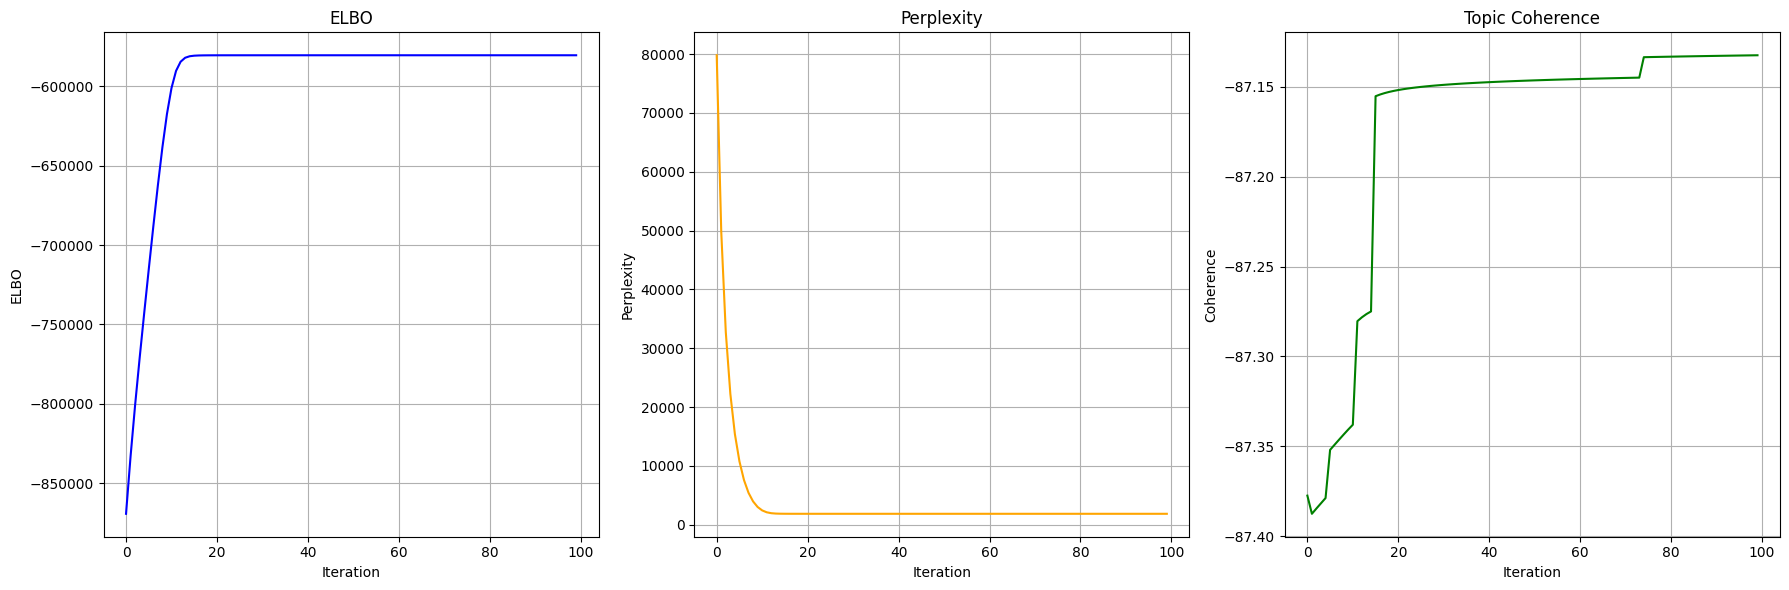

In [24]:
## 학습 과정 시각화

lda_vi.plot_result()

## **4-1. topic별 상위 단어 시각화**

In [25]:
def plot_top_words(lda_model, index_to_vocab, top_n=10):
  fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True)
  axes = axes.flatten()
  sns.set_palette("Set2", top_n)

  for topic_idx in range(lda_model.num_topic):
    top_word_indices = np.argsort(lda_model.beta[topic_idx])[-top_n:][::-1]
    top_words = [index_to_vocab[i] for i in top_word_indices]
    weights = lda_model.beta[topic_idx, top_word_indices]

    ax = axes[topic_idx]
    ax.barh(top_words, weights, color=sns.color_palette("husl", top_n))
    ax.set_title(f'Topic {topic_idx + 1}')
    ax.invert_yaxis()

  plt.tight_layout()
  plt.show()

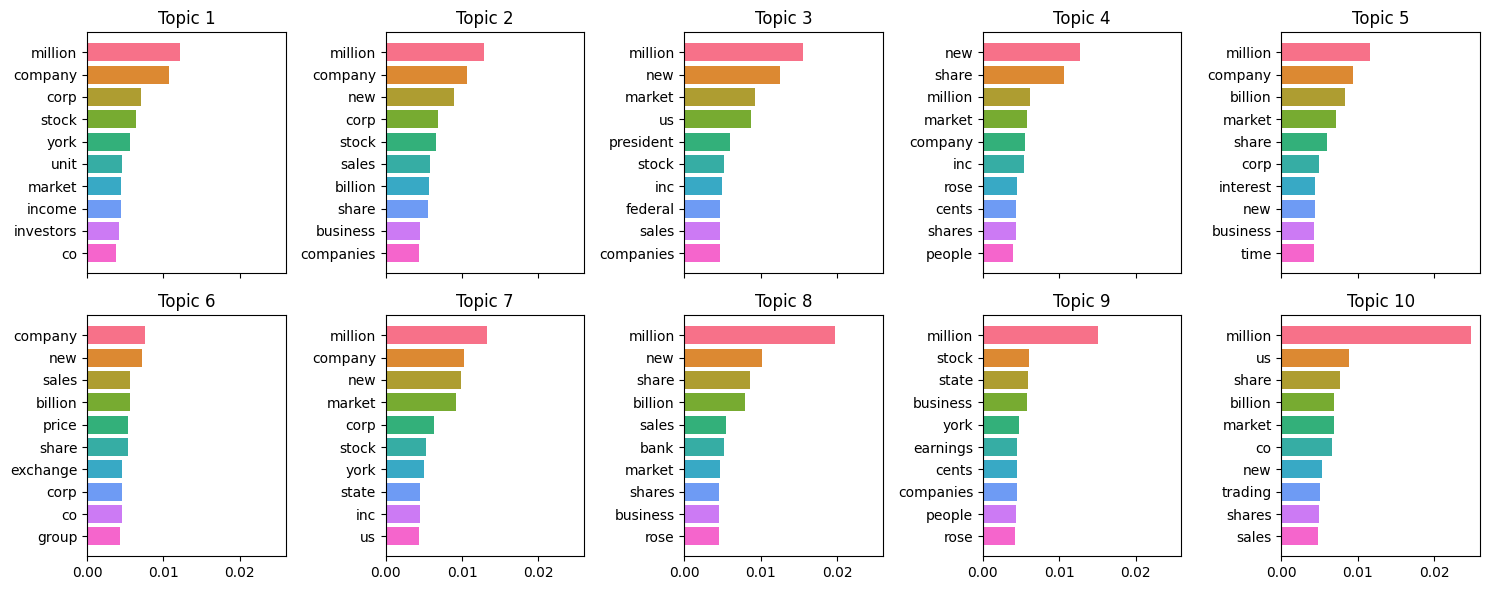

In [26]:
plot_top_words(lda_vi, i_t_v, top_n=10)

## **4-2. Topic 분포 시각화**

In [27]:
def plot_doc_topics(lda_model, num_docs=15, top_n=10):
  num_docs = min(num_docs, lda_model.num_docs)
  num_rows = (num_docs + 4) // 5
  num_topics = lda_model.num_topic

  fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows), sharey=True)
  sns.set_palette("Set2", num_topics)

  if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

  topic_labels = [f'{i + 1}' for i in range(num_topics)]

  for idx in range(num_docs):
    doc_topic_probs = lda_model.gamma[idx, :]
    top_topic_indices = doc_topic_probs.argsort()[-top_n:][::-1]
    weights = doc_topic_probs[top_topic_indices]

    row_idx = idx // 5
    col_idx = idx % 5
    ax = axes[row_idx, col_idx]

    ax.bar(topic_labels, weights, color=sns.color_palette("Set2", num_topics))
    ax.set_title(f'Doc {idx + 1}', fontsize=10)
    ax.set_xlabel('Topics', fontsize=8)
    ax.set_ylabel('Proportion', fontsize=8)
    ax.set_xticks(range(num_topics))
    ax.set_xticklabels(topic_labels, fontsize=8)

  plt.tight_layout()
  plt.show()

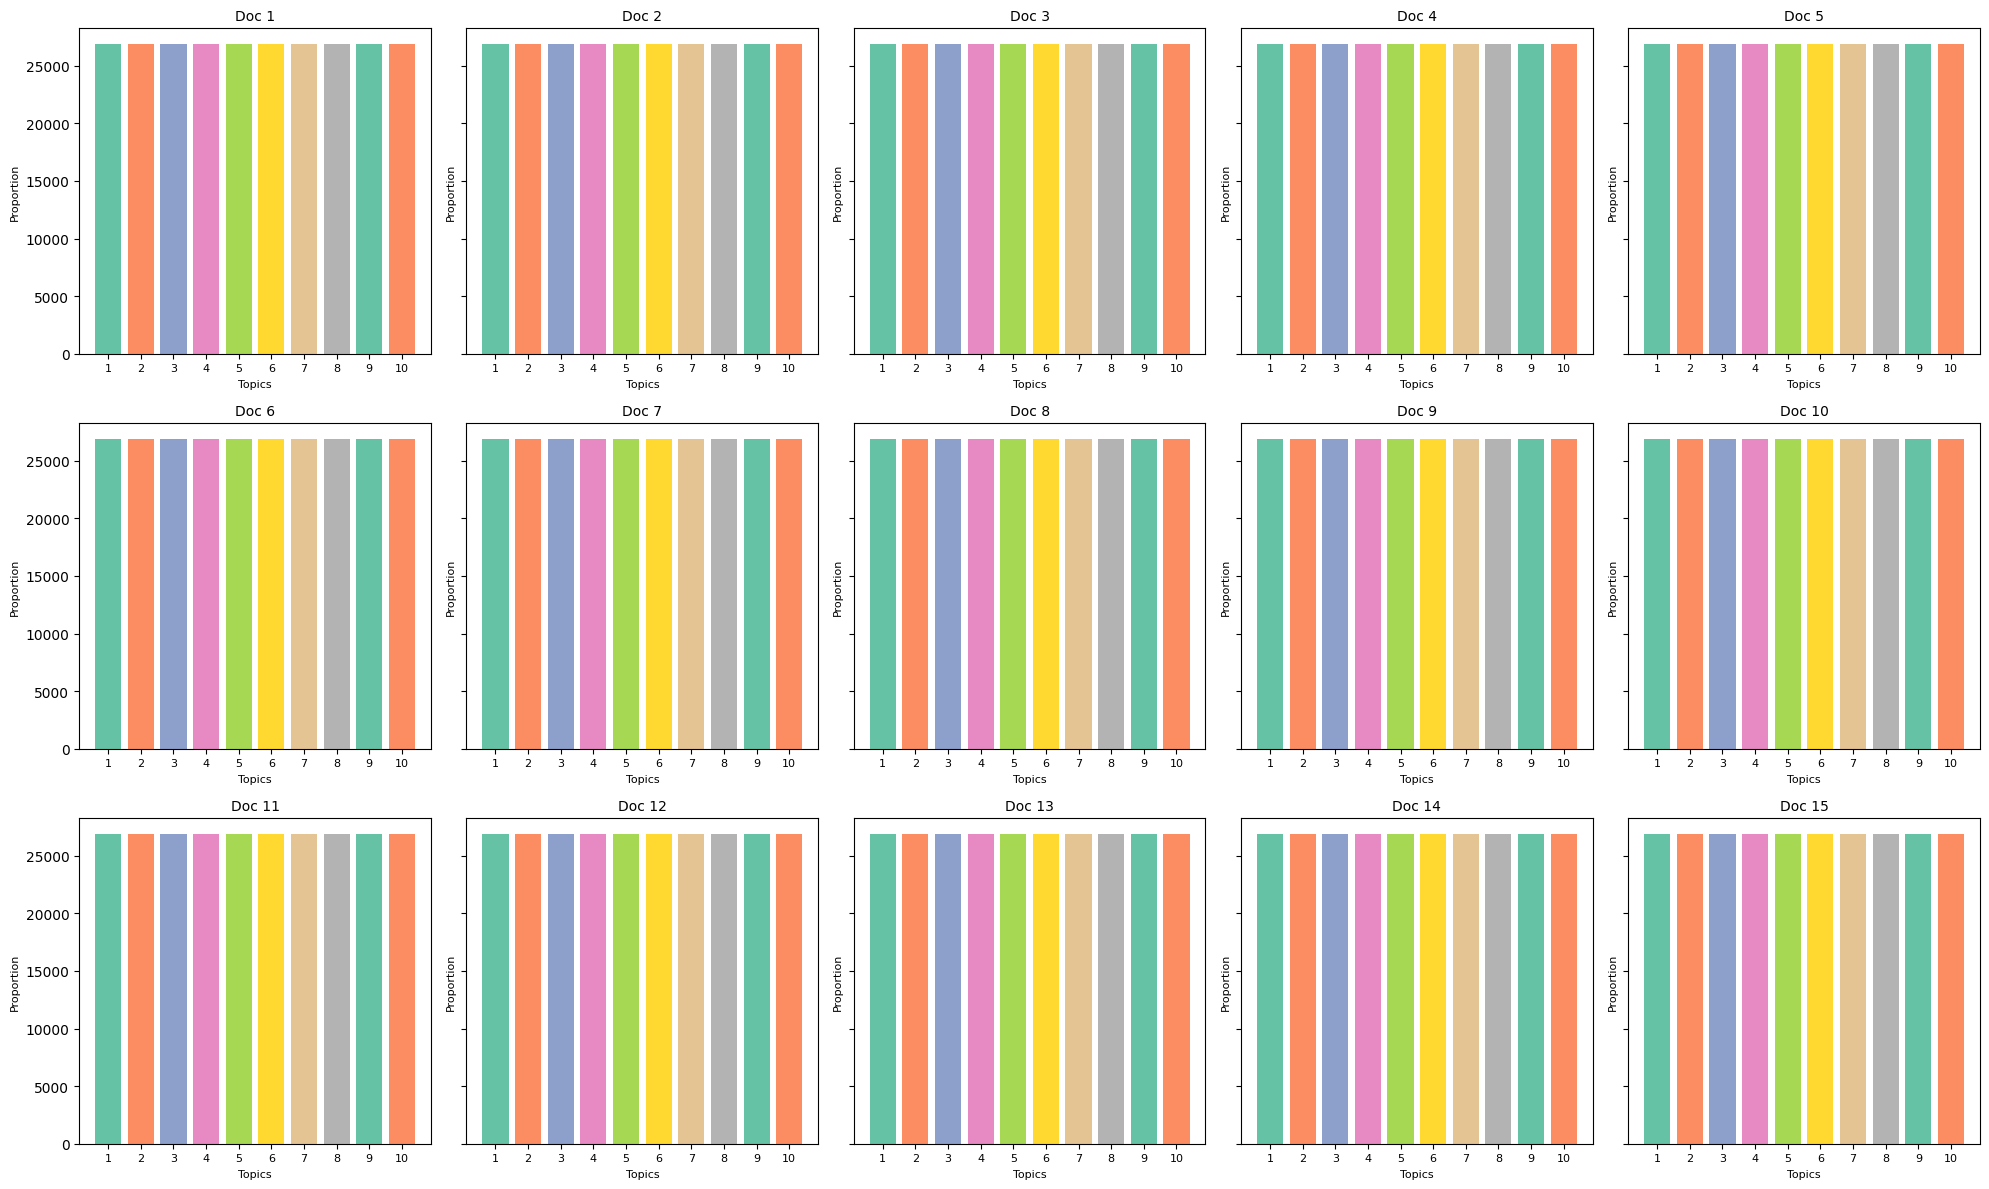

In [28]:
plot_doc_topics(lda_vi, num_docs=15, top_n=10)

## **4-3. Topic 할당 시각화**

In [29]:
## Topic 별 색상 지정

def generate_topic_colors(num_topics):
  cmap = plt.get_cmap("Set2", num_topics)
  return [to_hex(cmap(i)) for i in range(num_topics)]

In [30]:
## 단어의 topic 할당 확인

def get_topic_for_word(word, lda_model, vocab_to_index):
  word_id = vocab_to_index.get(word)
  if word_id is not None:
    topic_probs = lda_model.beta[:, word_id]
    return np.argmax(topic_probs)
  return None

In [31]:
def visualize_document(document, lda_model, vocab_to_index, topic_colors):
  html_content = '<html><head><style>'
  html_content += 'body {font-family: Arial, sans-serif;} '
  html_content += '.word {padding: 2px; margin: 2px; display: inline-block;} '
  html_content += '</style></head><body>'

  for word in document:
    word_id = vocab_to_index.get(word)
    if word_id is not None:
      topic = get_topic_for_word(word, lda_model, vocab_to_index)
      if topic is not None:
        color = topic_colors[topic]
        html_content += f'<span class="word" style="color: {color};">{word}</span>'
      else:
        html_content += f'<span class="word">{word}</span>'
    else:
      html_content += f'<span class="word">{word}</span>'

  html_content += '</body></html>'
  display(HTML(html_content))

In [32]:
topic_colors = generate_topic_colors(num_topics=10)
selected_docs = org_train_data[:15]
for i, doc in enumerate(selected_docs):
  print(f"Document {i + 1}")
  visualize_document(doc, lda_vi, v_t_i, topic_colors)

Document 1


Document 2


Document 3


Document 4


Document 5


Document 6


Document 7


Document 8


Document 9


Document 10


Document 11


Document 12


Document 13


Document 14


Document 15
